In [ ]:
import os
from os.path import join
from pathlib import Path
from collections import OrderedDict
from easydict import EasyDict as edict
import torch
import seaborn as sns
from matplotlib import cm
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem, ttest_ind, ttest_1samp, ttest_rel
from statsmodels.stats.multitest import fdrcorrection
import sys
sys.path.append(r"/Users/binxuwang/Github/Neuro-ActMax-GAN-comparison/")
from neuro_data_analysis.neural_data_utils import parse_meta, area_mapping, get_all_masks
from neuro_data_analysis.neural_data_lib import load_img_resp_pairs, load_neural_data, get_expstr, \
    extract_evol_activation_array, extract_evol_psth_array, extract_all_evol_trajectory_psth, pad_psth_traj
from core.utils.stats_utils import ttest_rel_print, ttest_ind_print
from core.utils.plot_utils import saveallforms, show_imgrid

In [7]:
source_data_dir = r"/Users/binxuwang/Library/CloudStorage/OneDrive-HarvardUniversity/Manuscript_BigGAN/Submissions/Manuscript_BigGAN - NatNeuro/2025-10-Accepted-In-Principle-Docs/SourceData/ExtendedFig4_Source_data"

### Ext Figure 4B

In [8]:

def mean_time_bin(psth, bin_size=5):
    """Bin the psth in time axis and return the mean of each bin."""
    n_timepoint = psth.shape[-1]
    n_bin = n_timepoint // bin_size
    psth_bin = psth[..., :n_bin*bin_size].reshape(psth.shape[:-1] + (n_bin, bin_size))
    return psth_bin.mean(axis=-1)

In [4]:
tabdir = Path(r"/Users/binxuwang/Library/CloudStorage/OneDrive-HarvardUniversity/Manuscript_BigGAN/Stats_tables")
meta_df = pd.read_csv(tabdir / "meta_activation_stats.csv", index_col=0)
Amsk, Bmsk, V1msk, V4msk, ITmsk, length_msk, spc_msk, \
    sucsmsk, bsl_unstable_msk, bsl_stable_msk, validmsk = get_all_masks(meta_df)
#%%
_, BFEStats = load_neural_data()
psth_col, _ = extract_all_evol_trajectory_psth(BFEStats)
psth_extrap_arr, extrap_mask_arr, max_len = pad_psth_traj(psth_col)

total number of experiments: 170
total number of valid experiments: 154
total number of valid experiments with suc: 133
Exluded:
  - short: 8
  - unstable baseline: 6
  - not fc6-BigGAN: 3
Exp 003 Beto-22072020-002 Pref chan5 U2
image size [3. 3.] deg  pos [-0.7  1. ]
Evol thr0: fc6   thr1: BigGAN_class
Exp 004 Beto-22072020-003 Pref chan5 U2
image size [6. 6.] deg  pos [-0.7  1. ]
Evol thr0: BigGAN_class   thr1: BigGAN_class
Exp 005 Beto-23072020-002 Pref chan29 U2
image size [3. 3.] deg  pos [-0.8  1. ]
Evol thr0: fc6   thr1: BigGAN_class
Exp 006 Beto-27072020-002 Pref chan26 U1
image size [3. 3.] deg  pos [-1.1  0. ]
Evol thr0: fc6   thr1: BigGAN_class
Exp 007 Beto-28072020-003 Pref chan15 U1
image size [3. 3.] deg  pos [-0.5  1. ]
Evol thr0: fc6   thr1: BigGAN
Exp 008 Beto-28072020-006 Pref chan15 U1
image size [3. 3.] deg  pos [-0.5  1. ]
Evol thr0: BigGAN_class   thr1: BigGAN
Exp 009 Beto-29072020-002 Pref chan28 U1
image size [3. 3.] deg  pos [0.  0.5]
Evol thr0: fc6   thr1: Big

In [5]:
diff_attrib_tsr = []
diff_attrib_norm_tsr = []
diff_attrib_sem_tsr = []
diff_attrib_bin_tsr = []
diff_attrib_norm_bin_tsr = []
diff_attrib_sem_bin_tsr = []
stat_dict = []
bin_size = 5 # 5 10 20 25 50 
bin_str = f"{bin_size}ms_wdw"
for thread in range(2):
    mean_act_arr_thread = psth_extrap_arr[:, :, thread, 50:].mean(axis=-1)
    max_block = mean_act_arr_thread.argmax(axis=1)
    # gather the psth of the max block, gather the psth of the first block
    max_psth_mean = np.take_along_axis(psth_extrap_arr[:, :, thread+0, :], max_block[:, None, None], axis=1).squeeze(axis=1)
    max_psth_sem  = np.take_along_axis(psth_extrap_arr[:, :, thread+2, :], max_block[:, None, None], axis=1).squeeze(axis=1)
    first_psth_mean = psth_extrap_arr[:, 0, thread+0, :]
    first_psth_sem  = psth_extrap_arr[:, 0, thread+2, :]
    diff_attrib = max_psth_mean - first_psth_mean
    diff_attrib_norm = diff_attrib / diff_attrib.sum(axis=1, keepdims=True)
    diff_attrib_sem = np.sqrt((max_psth_sem**2 + first_psth_sem**2) / 2)
    #TODO: better way to do the sem uncertainty.

    psth_arr_thread = psth_extrap_arr[:, :, thread, :]
    max_psth_mean_bin = mean_time_bin(max_psth_mean, bin_size=bin_size)
    max_psth_sem_bin = mean_time_bin(max_psth_sem, bin_size=bin_size)
    first_psth_mean_bin = mean_time_bin(first_psth_mean, bin_size=bin_size)
    first_psth_sem_bin = mean_time_bin(first_psth_sem, bin_size=bin_size)
    diff_attrib_bin = max_psth_mean_bin - first_psth_mean_bin
    diff_attrib_norm_bin = diff_attrib_bin / diff_attrib_bin.sum(axis=1, keepdims=True)
    diff_attrib_sem_bin = np.sqrt((max_psth_sem_bin**2 + first_psth_mean_bin**2) / 2)

    diff_attrib_tsr.append(diff_attrib)
    diff_attrib_norm_tsr.append(diff_attrib_norm)
    diff_attrib_sem_tsr.append(diff_attrib_sem)
    diff_attrib_bin_tsr.append(diff_attrib_bin)
    diff_attrib_norm_bin_tsr.append(diff_attrib_norm_bin)
    diff_attrib_sem_bin_tsr.append(diff_attrib_sem_bin)

diff_attrib_tsr = np.stack(diff_attrib_tsr, axis=-1)
diff_attrib_norm_tsr = np.stack(diff_attrib_norm_tsr, axis=-1)
diff_attrib_sem_tsr = np.stack(diff_attrib_sem_tsr, axis=-1)
diff_attrib_bin_tsr = np.stack(diff_attrib_bin_tsr, axis=-1)
diff_attrib_norm_bin_tsr = np.stack(diff_attrib_norm_bin_tsr, axis=-1)
diff_attrib_sem_bin_tsr = np.stack(diff_attrib_sem_bin_tsr, axis=-1)

/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_49951/853440762.py:19: RuntimeWarning: invalid value encountered in divide
  diff_attrib_norm = diff_attrib / diff_attrib.sum(axis=1, keepdims=True)
/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_49951/853440762.py:29: RuntimeWarning: invalid value encountered in divide
  diff_attrib_norm_bin = diff_attrib_bin / diff_attrib_bin.sum(axis=1, keepdims=True)


In [6]:
diff_attrib_norm_bin_tsr.shape

(170, 40, 2)

In [9]:
bin_size = 5 # 5 10 20 25 50 
for bin_size in [5, 10, 20, 25, 50]:
    diff_attrib_tsr = []
    diff_attrib_norm_tsr = []
    diff_attrib_sem_tsr = []
    diff_attrib_bin_tsr = []
    diff_attrib_norm_bin_tsr = []
    diff_attrib_sem_bin_tsr = []
    bin_str = f"{bin_size}ms_wdw"
    for thread in range(2):
        mean_act_arr_thread = psth_extrap_arr[:, :, thread, 50:].mean(axis=-1)
        max_block = mean_act_arr_thread.argmax(axis=1)
        # gather the psth of the max block, gather the psth of the first block
        max_psth_mean = np.take_along_axis(psth_extrap_arr[:, :, thread+0, :], max_block[:, None, None], axis=1).squeeze(axis=1)
        max_psth_sem  = np.take_along_axis(psth_extrap_arr[:, :, thread+2, :], max_block[:, None, None], axis=1).squeeze(axis=1)
        first_psth_mean = psth_extrap_arr[:, 0, thread+0, :]
        first_psth_sem  = psth_extrap_arr[:, 0, thread+2, :]
        diff_attrib = max_psth_mean - first_psth_mean
        diff_attrib_norm = diff_attrib / diff_attrib.sum(axis=1, keepdims=True)
        diff_attrib_sem = np.sqrt((max_psth_sem**2 + first_psth_sem**2) / 2)
        #TODO: better way to do the sem uncertainty.

        psth_arr_thread = psth_extrap_arr[:, :, thread, :]
        max_psth_mean_bin = mean_time_bin(max_psth_mean, bin_size=bin_size)
        max_psth_sem_bin = mean_time_bin(max_psth_sem, bin_size=bin_size)
        first_psth_mean_bin = mean_time_bin(first_psth_mean, bin_size=bin_size)
        first_psth_sem_bin = mean_time_bin(first_psth_sem, bin_size=bin_size)
        diff_attrib_bin = max_psth_mean_bin - first_psth_mean_bin
        diff_attrib_norm_bin = diff_attrib_bin / diff_attrib_bin.sum(axis=1, keepdims=True)
        diff_attrib_sem_bin = np.sqrt((max_psth_sem_bin**2 + first_psth_mean_bin**2) / 2)

        diff_attrib_tsr.append(diff_attrib)
        diff_attrib_norm_tsr.append(diff_attrib_norm)
        diff_attrib_sem_tsr.append(diff_attrib_sem)
        diff_attrib_bin_tsr.append(diff_attrib_bin)
        diff_attrib_norm_bin_tsr.append(diff_attrib_norm_bin)
        diff_attrib_sem_bin_tsr.append(diff_attrib_sem_bin)

    diff_attrib_tsr = np.stack(diff_attrib_tsr, axis=-1)
    diff_attrib_norm_tsr = np.stack(diff_attrib_norm_tsr, axis=-1)
    diff_attrib_sem_tsr = np.stack(diff_attrib_sem_tsr, axis=-1)
    diff_attrib_bin_tsr = np.stack(diff_attrib_bin_tsr, axis=-1)
    diff_attrib_norm_bin_tsr = np.stack(diff_attrib_norm_bin_tsr, axis=-1)
    diff_attrib_sem_bin_tsr = np.stack(diff_attrib_sem_bin_tsr, axis=-1)
    DeePSim_df = pd.DataFrame(diff_attrib_norm_bin_tsr[:,:,0])
    BigGAN_df = pd.DataFrame(diff_attrib_norm_bin_tsr[:,:,1])
    DeePSim_df.to_csv(join(source_data_dir, f"FigureExt4B_DeePSim_diff_attrib_norm_bin_tsr_{bin_size}ms.csv"))
    BigGAN_df.to_csv(join(source_data_dir, f"FigureExt4B_BigGAN_diff_attrib_norm_bin_tsr_{bin_size}ms.csv"))

/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_49951/528839158.py:19: RuntimeWarning: invalid value encountered in divide
  diff_attrib_norm = diff_attrib / diff_attrib.sum(axis=1, keepdims=True)
/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_49951/528839158.py:29: RuntimeWarning: invalid value encountered in divide
  diff_attrib_norm_bin = diff_attrib_bin / diff_attrib_bin.sum(axis=1, keepdims=True)


In [14]:

from statsmodels.stats.multitest import fdrcorrection

In [19]:
meta_df["valid"] = validmsk
meta_df.to_csv(join(source_data_dir, f"FigureExt4_meta_df.csv"))
V1msk = meta_df.visual_area == "V1"
V4msk = meta_df.visual_area == "V4"
ITmsk = meta_df.visual_area == "IT"
validmsk = meta_df.valid
bothsucsmsk = (meta_df.p_maxinit_0 < 0.05) & (meta_df.p_maxinit_1 < 0.05)
FCsucsmsk = (meta_df.p_maxinit_0 < 0.05)
BGsucsmsk = (meta_df.p_maxinit_1 < 0.05)

### Figure Reproduce

/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_49951/2426647030.py:27: RuntimeWarning: Mean of empty slice.
  diff_attrib = diff_attrib_norm_bin_tsr[mask].mean(axis=0)
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


V1 orig [] []
V1 fdr [] []
V4 orig [0.04382247 0.01714281 0.02669742 0.04303574 0.00904546] [ 2.06324238  2.45816722 -2.27701719 -2.07129273 -2.70621751]
V4 fdr [] []
IT orig [0.01806748 0.00376787 0.0081559  0.04150508 0.04675247 0.01156565
 0.00831286] [ 2.39455818  2.95018032  2.68683546 -2.0588551  -2.0076597  -2.56143086
 -2.68010133]
IT fdr [] []


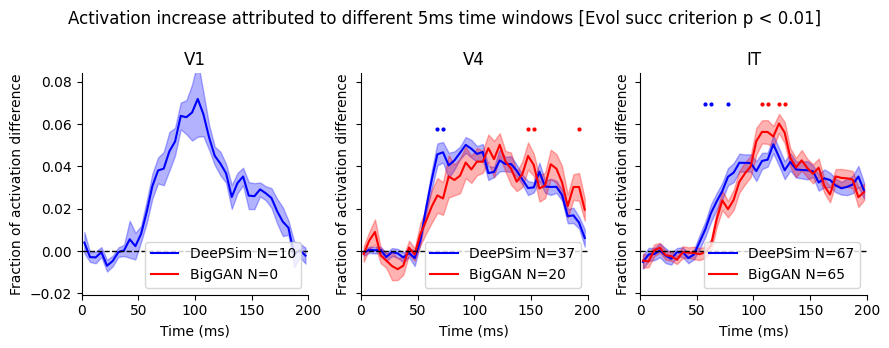

/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_49951/2426647030.py:27: RuntimeWarning: Mean of empty slice.
  diff_attrib = diff_attrib_norm_bin_tsr[mask].mean(axis=0)
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


V1 orig [] []
V1 fdr [] []
V4 orig [0.00717943] [-2.79255728]
V4 fdr [] []
IT orig [0.03388063 0.01117427 0.0351795  0.00357843] [ 2.14416367  2.5739849  -2.12853235 -2.96716577]
IT fdr [] []


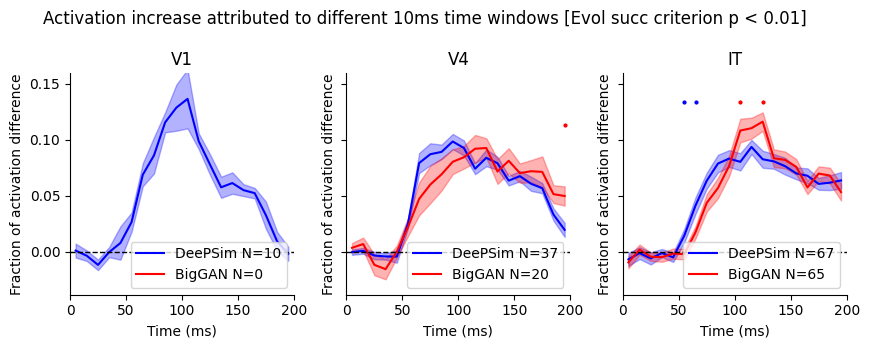

V1 orig [] []
V1 fdr [] []
V4 orig [0.00636915] [-2.83669485]
V4 fdr [] []
IT orig [0.00855938 0.02247866 0.04111892] [ 2.66975324 -2.30974311 -2.06283744]
IT fdr [] []


/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_49951/2426647030.py:27: RuntimeWarning: Mean of empty slice.
  diff_attrib = diff_attrib_norm_bin_tsr[mask].mean(axis=0)
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


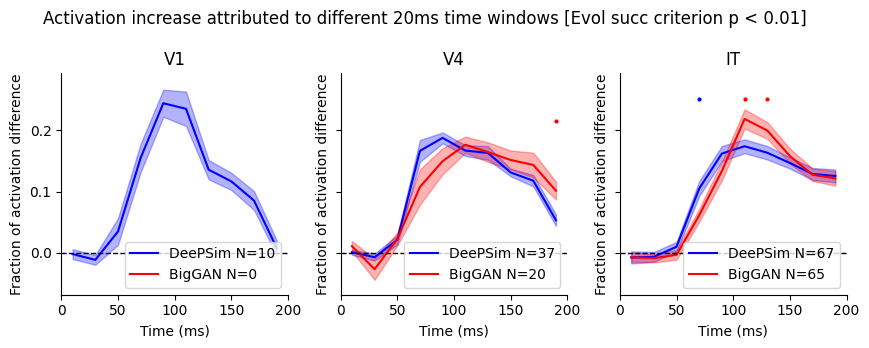

/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_49951/2426647030.py:27: RuntimeWarning: Mean of empty slice.
  diff_attrib = diff_attrib_norm_bin_tsr[mask].mean(axis=0)
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


V1 orig [] []
V1 fdr [] []
V4 orig [0.0488992  0.01298665] [ 2.01411264 -2.56766499]
V4 fdr [] []
IT orig [0.00546227 0.00731719] [ 2.82575315 -2.72494282]
IT fdr [0.02926875 0.02926875] [ 2.82575315 -2.72494282]


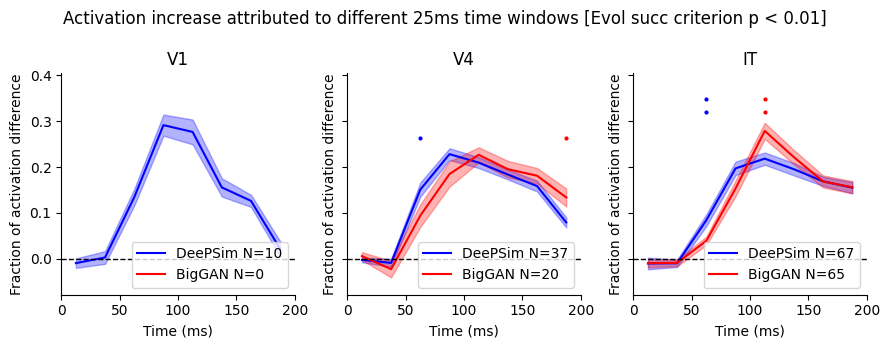

/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_49951/2426647030.py:27: RuntimeWarning: Mean of empty slice.
  diff_attrib = diff_attrib_norm_bin_tsr[mask].mean(axis=0)
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


V1 orig [] []
V1 fdr [] []
V4 orig [0.0496293  0.02123055] [ 2.00741362 -2.37176857]
V4 fdr [] []
IT orig [0.00358299 0.00378576] [ 2.96674716 -2.94861674]
IT fdr [0.00757153 0.00757153] [ 2.96674716 -2.94861674]


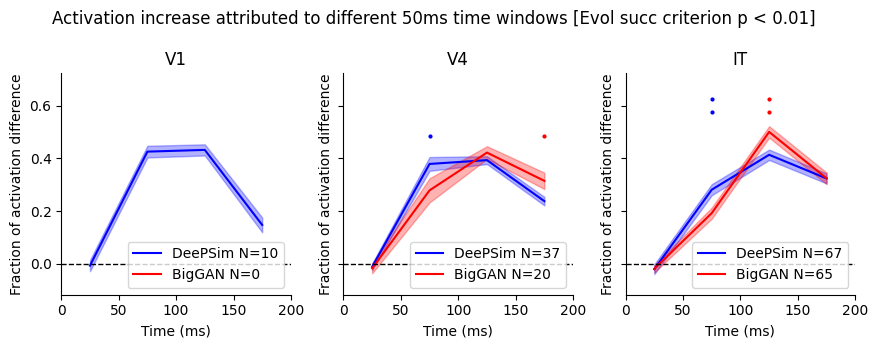

In [23]:
meta_df = pd.read_csv(join(source_data_dir, f"FigureExt4_meta_df.csv"), index_col=0)
V1msk = meta_df.visual_area == "V1"
V4msk = meta_df.visual_area == "V4"
ITmsk = meta_df.visual_area == "IT"
validmsk = meta_df.valid
thresh = 0.01
bothsucsmsk = (meta_df.p_maxinit_0 < thresh) & (meta_df.p_maxinit_1 < thresh)
FCsucsmsk = (meta_df.p_maxinit_0 < thresh)
BGsucsmsk = (meta_df.p_maxinit_1 < thresh)
bin_size = 5 # 5 10 20 25 50 
for bin_size in [5, 10, 20, 25, 50]:
    DeePSim_df = pd.read_csv(join(source_data_dir, f"FigureExt4B_DeePSim_diff_attrib_norm_bin_tsr_{bin_size}ms.csv"), index_col=0)
    BigGAN_df = pd.read_csv(join(source_data_dir, f"FigureExt4B_BigGAN_diff_attrib_norm_bin_tsr_{bin_size}ms.csv"), index_col=0)
    diff_attrib_norm_bin_tsr = np.stack([DeePSim_df.values, BigGAN_df.values], axis=-1)

    thread_colors = ['b', 'r']
    figh, axs = plt.subplots(1, 3, figsize=[9, 3.5], sharex=True, sharey=True)
    time_ticks = np.arange(0, 200, bin_size) + bin_size / 2
    for i, (visual_area, area_mask) in enumerate(zip(["V1", "V4", "IT"], [V1msk, V4msk, ITmsk])):
        ax = axs[i]
        diff_attrib_both = np.zeros((2, diff_attrib_norm_bin_tsr.shape[1]))
        for thread, GANname, thread_sucsmsk in zip([0, 1],
                                                ["DeePSim", "BigGAN"],
                                                [FCsucsmsk, BGsucsmsk]):

            mask = area_mask & validmsk & thread_sucsmsk
            diff_attrib = diff_attrib_norm_bin_tsr[mask].mean(axis=0)
            diff_attrib_sem = diff_attrib_norm_bin_tsr[mask].std(axis=0) / np.sqrt(mask.sum())
            diff_attrib_both[thread, :] = diff_attrib[:, thread]
            ax.plot(time_ticks, diff_attrib[:, thread], color=thread_colors[thread],
                    label=f"{GANname} N={mask.sum()}")
            ax.fill_between(time_ticks,
                            diff_attrib[:, thread] - diff_attrib_sem[:, thread],
                            diff_attrib[:, thread] + diff_attrib_sem[:, thread], color=thread_colors[thread], alpha=0.3)
        pvals = []
        tvals = []
        for t in range(diff_attrib_norm_bin_tsr.shape[1]):
            tval, p = ttest_ind(diff_attrib_norm_bin_tsr[area_mask & validmsk & FCsucsmsk][:,t,0], 
                                diff_attrib_norm_bin_tsr[area_mask & validmsk & BGsucsmsk][:,t,1])
            pvals.append(p)
            tvals.append(tval)
        
        pvals = np.array(pvals)
        tvals = np.array(tvals)
        signif_orig = pvals < 0.05
        fdr_reject, pvals_fdr = fdrcorrection(pvals, alpha=0.05)
        signif_fdr = fdr_reject # pvals_fdr < 0.05
        for signif, signif_str, y_offset in zip([signif_orig, signif_fdr], ["orig", "fdr"], [0, 0.1]):
            annot_y = diff_attrib_both.max() * (1.15 + y_offset)
            ax.plot(time_ticks[(tvals > 0) & signif], np.ones(np.sum((tvals > 0) & signif))*annot_y, 'b.', markersize=4)
            ax.plot(time_ticks[(tvals < 0) & signif], np.ones(np.sum((tvals < 0) & signif))*annot_y, 'r.', markersize=4)
        print(visual_area, "orig", pvals[signif_orig], tvals[signif_orig])
        print(visual_area, "fdr", pvals_fdr[signif_fdr], tvals[signif_fdr])
        
        ax.axhline(0, color='k', ls='--', lw=1)
        ax.set_title(visual_area)
        ax.set_xlabel("Time (ms)")
        ax.set_ylabel("Fraction of activation difference")
        ax.set_xlim([0, 200])
        # ax.set_ylim([-0.05, 0.30])
        ax.legend(loc="lower right")
    for ax in axs:
        ax.relim()           # Re-compute the data limits
        ax.margins(y=0.15)
        ax.autoscale_view()  # Update the view to the new limits
    plt.suptitle(f"Activation increase attributed to different {bin_size}ms time windows [Evol succ criterion p < {thresh}]")
    plt.tight_layout()
    # saveallforms(figdir, f"act_increase_attrib_threadsucs_3area_thr{thresh}_{bin_str}", figh)
    plt.show()


### Ext Figure 4C

In [28]:
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
def pad_normalize_multi_wdw_resp_trajs(rsp_wdws, resp_col_multi_wdw, full_normalizer, ):
    normresp_extrap_arr_univ_col = {}
    for colj, rsp_wdw in enumerate(rsp_wdws):
        # resp_col, _ = extract_all_evol_trajectory_dyna(BFEStats, rsp_wdw=rsp_wdw)
        resp_col = resp_col_multi_wdw[colj]
        resp_extrap_arr, extrap_mask_arr, max_len = pad_resp_traj(resp_col)
        normresp_extrap_arr_univ = resp_extrap_arr / full_normalizer
        normresp_extrap_arr_univ_col[rsp_wdw] = normresp_extrap_arr_univ
    return normresp_extrap_arr_univ_col


def plot_normalized_response_trajectories_from_precomputed_normresp(normresp_extrap_arr_univ_col, area_masks, area_labels,
                                          commonmsk, signif_test=False, signif_alpha=0.05, plot_individual_exp=True,
                                          mcc_corrections=["nomcc", "fdr", "bonf"],
                                          panel_width=3, panel_height=3):

    figh, axs = plt.subplots(len(area_masks), len(rsp_wdws), figsize=(panel_width * len(rsp_wdws), panel_height * len(area_masks) + .5), sharey="row", )
    for colj, (rsp_wdw, normresp_extrap_arr_univ) in enumerate(normresp_extrap_arr_univ_col.items()):
        for rowi, (msk_major, label_major) in enumerate(zip(area_masks, area_labels)):
            msk = msk_major & commonmsk
            if plot_individual_exp:
                axs[rowi, colj].plot(normresp_extrap_arr_univ[msk, :, 0].T, color="blue", alpha=0.2, lw=0.7, label=None)
                axs[rowi, colj].plot(normresp_extrap_arr_univ[msk, :, 1].T, color="red", alpha=0.2, lw=0.7, label=None)
            
            mean_trace_FC = normresp_extrap_arr_univ[msk, :, 0].mean(axis=0)
            sem_trace_FC = normresp_extrap_arr_univ[msk, :, 0].std(axis=0) / np.sqrt(msk.sum())
            mean_trace_BG = normresp_extrap_arr_univ[msk, :, 1].mean(axis=0)
            sem_trace_BG = normresp_extrap_arr_univ[msk, :, 1].std(axis=0) / np.sqrt(msk.sum())
            axs[rowi, colj].plot(mean_trace_FC, color="blue", lw=3, label="DeePSim")
            axs[rowi, colj].fill_between(np.arange(len(mean_trace_FC)),
                                         mean_trace_FC - sem_trace_FC,
                                         mean_trace_FC + sem_trace_FC,
                                         color="blue", alpha=0.25, label=None)
            axs[rowi, colj].plot(mean_trace_BG, color="red", lw=3, label="BigGAN")
            axs[rowi, colj].fill_between(np.arange(len(mean_trace_BG)),
                                         mean_trace_BG - sem_trace_BG,
                                         mean_trace_BG + sem_trace_BG,
                                         color="red", alpha=0.25, label=None)
            axs[rowi, colj].set_title(f"[{rsp_wdw[0]}, {rsp_wdw[-1] + 1}ms]")
            if colj == 0:
                axs[rowi, 0].set_ylabel(f"Max Normalized Response\n{label_major} (N={msk.sum()})")
            
            if signif_test:
                # We'll do a two-sample t-test at each time point comparing FC vs BG
                FC_arr = normresp_extrap_arr_univ[msk, :, 0]  # shape: (num_units, time)
                BG_arr = normresp_extrap_arr_univ[msk, :, 1]  # shape: (num_units, time)

                pvals = []
                tstat_signs = []  # Store which value is larger
                for t in range(FC_arr.shape[1]):
                    # paired t test
                    tstat, p = stats.ttest_rel(FC_arr[:, t], BG_arr[:, t])
                    pvals.append(p)
                    tstat_signs.append(tstat > 0)  # True if FC > BG
                pvals = np.array(pvals)
                tstat_signs = np.array(tstat_signs)
                sig_mask_nomcc = pvals < signif_alpha
                # Multiple comparison correction
                # FDR correction
                alpha = signif_alpha  # significance threshold
                reject, pvals_fdr, _, _ = multipletests(pvals, alpha=alpha, method='fdr_bh')
                sig_mask_fdr = reject  # Boolean array: True if significant at alpha
                # Bonferroni correction 
                pvals_bonf = pvals * len(pvals)  # Multiply by number of comparisons
                sig_mask_bonf = pvals_bonf < signif_alpha

                # Plot both FDR and Bonferroni significant points at different heights
                for mcc_correction in mcc_corrections:
                    if mcc_correction == "nomcc":
                        # Split into FC>BG and BG>FC points
                        fc_higher = sig_mask_nomcc & tstat_signs
                        bg_higher = sig_mask_nomcc & ~tstat_signs
                        axs[rowi, colj].plot(np.where(fc_higher)[0],
                                    np.ones(np.sum(fc_higher))*1.3,
                                    'b.', markersize=4,
                                    label=f'p<{signif_alpha}' if colj==0 and rowi==0 else "")
                        axs[rowi, colj].plot(np.where(bg_higher)[0],
                                    np.ones(np.sum(bg_higher))*1.3,
                                    'r.', markersize=4,
                                    label=None)
                    elif mcc_correction == "fdr":
                        fc_higher = sig_mask_fdr & tstat_signs
                        bg_higher = sig_mask_fdr & ~tstat_signs
                        axs[rowi, colj].plot(np.where(fc_higher)[0],
                                    np.ones(np.sum(fc_higher))*1.35,
                                    'b.', markersize=4,
                                    label=f'FDR p<{signif_alpha}' if colj==0 and rowi==0 else "")
                        axs[rowi, colj].plot(np.where(bg_higher)[0],
                                    np.ones(np.sum(bg_higher))*1.35,
                                    'r.', markersize=4,
                                    label=None)
                    elif mcc_correction == "bonf":
                        fc_higher = sig_mask_bonf & tstat_signs
                        bg_higher = sig_mask_bonf & ~tstat_signs
                        axs[rowi, colj].plot(np.where(fc_higher)[0],
                                    np.ones(np.sum(fc_higher))*1.40,
                                    'b.', markersize=4,
                                    label=f'Bonf p<{signif_alpha}' if colj==0 and rowi==0 else "")
                        axs[rowi, colj].plot(np.where(bg_higher)[0],
                                    np.ones(np.sum(bg_higher))*1.40,
                                    'r.', markersize=4,
                                    label=None)

    for ax in axs.ravel():
        ax.set_xlim([-0.5, 45.5])
        ax.set_ylim([0, 1.5])

    axs[0, 0].legend(loc="upper right", frameon=False)
    plt.show()
    return figh

In [30]:
from neuro_data_analysis.neural_data_lib import extract_all_evol_trajectory_dyna, \
    pad_resp_traj, extract_all_evol_trajectory_dyna_multiwindow_nostats

In [31]:
_, BFEStats = load_neural_data()
resp_col, meta_df = extract_all_evol_trajectory_dyna(BFEStats, rsp_wdw=range(50, 200))
resp_extrap_arr, extrap_mask_arr, max_len = pad_resp_traj(resp_col)
full_normalizer = resp_extrap_arr[:, :, 0:2].max(axis=(1, 2), keepdims=True)

Exp 003 Beto-22072020-002 Pref chan5 U2
image size [3. 3.] deg  pos [-0.7  1. ]
Evol thr0: fc6   thr1: BigGAN_class
Exp 004 Beto-22072020-003 Pref chan5 U2
image size [6. 6.] deg  pos [-0.7  1. ]
Evol thr0: BigGAN_class   thr1: BigGAN_class
Exp 005 Beto-23072020-002 Pref chan29 U2
image size [3. 3.] deg  pos [-0.8  1. ]
Evol thr0: fc6   thr1: BigGAN_class
Exp 006 Beto-27072020-002 Pref chan26 U1
image size [3. 3.] deg  pos [-1.1  0. ]
Evol thr0: fc6   thr1: BigGAN_class
Exp 007 Beto-28072020-003 Pref chan15 U1
image size [3. 3.] deg  pos [-0.5  1. ]
Evol thr0: fc6   thr1: BigGAN
Exp 008 Beto-28072020-006 Pref chan15 U1
image size [3. 3.] deg  pos [-0.5  1. ]
Evol thr0: BigGAN_class   thr1: BigGAN
Exp 009 Beto-29072020-002 Pref chan28 U1
image size [3. 3.] deg  pos [0.  0.5]
Evol thr0: fc6   thr1: BigGAN_class
Exp 010 Beto-29072020-003 Pref chan18 U1
image size [4. 4.] deg  pos [-0.5  1. ]
Evol thr0: fc6   thr1: BigGAN_class
Exp 012 Beto-31072020-003 Pref chan29 U2
image size [3. 3.] de

In [24]:

# Amsk, Bmsk, V1msk, V4msk, ITmsk, \
#     length_msk, spc_msk, sucsmsk, \
#     bsl_unstable_msk, bsl_stable_msk, validmsk = get_all_masks(meta_df)
# bothsucsmsk = (meta_df.p_maxinit_0 < 0.05) & (meta_df.p_maxinit_1 < 0.05)
# FCsucsmsk = (meta_df.p_maxinit_0 < 0.05)
# BGsucsmsk = (meta_df.p_maxinit_1 < 0.05)
meta_df = pd.read_csv(join(source_data_dir, f"FigureExt4_meta_df.csv"), index_col=0)
V1msk = meta_df.visual_area == "V1"
V4msk = meta_df.visual_area == "V4"
ITmsk = meta_df.visual_area == "IT"
validmsk = meta_df.valid
thresh = 0.05
bothsucsmsk = (meta_df.p_maxinit_0 < thresh) & (meta_df.p_maxinit_1 < thresh)
FCsucsmsk = (meta_df.p_maxinit_0 < thresh)
BGsucsmsk = (meta_df.p_maxinit_1 < thresh)

Exp 003 Beto-22072020-002 Pref chan5 U2
image size [3. 3.] deg  pos [-0.7  1. ]
Evol thr0: fc6   thr1: BigGAN_class
Exp 004 Beto-22072020-003 Pref chan5 U2
image size [6. 6.] deg  pos [-0.7  1. ]
Evol thr0: BigGAN_class   thr1: BigGAN_class
Exp 005 Beto-23072020-002 Pref chan29 U2
image size [3. 3.] deg  pos [-0.8  1. ]
Evol thr0: fc6   thr1: BigGAN_class
Exp 006 Beto-27072020-002 Pref chan26 U1
image size [3. 3.] deg  pos [-1.1  0. ]
Evol thr0: fc6   thr1: BigGAN_class
Exp 007 Beto-28072020-003 Pref chan15 U1
image size [3. 3.] deg  pos [-0.5  1. ]
Evol thr0: fc6   thr1: BigGAN
Exp 008 Beto-28072020-006 Pref chan15 U1
image size [3. 3.] deg  pos [-0.5  1. ]
Evol thr0: BigGAN_class   thr1: BigGAN
Exp 009 Beto-29072020-002 Pref chan28 U1
image size [3. 3.] deg  pos [0.  0.5]
Evol thr0: fc6   thr1: BigGAN_class
Exp 010 Beto-29072020-003 Pref chan18 U1
image size [4. 4.] deg  pos [-0.5  1. ]
Evol thr0: fc6   thr1: BigGAN_class
Exp 012 Beto-31072020-003 Pref chan29 U2
image size [3. 3.] de

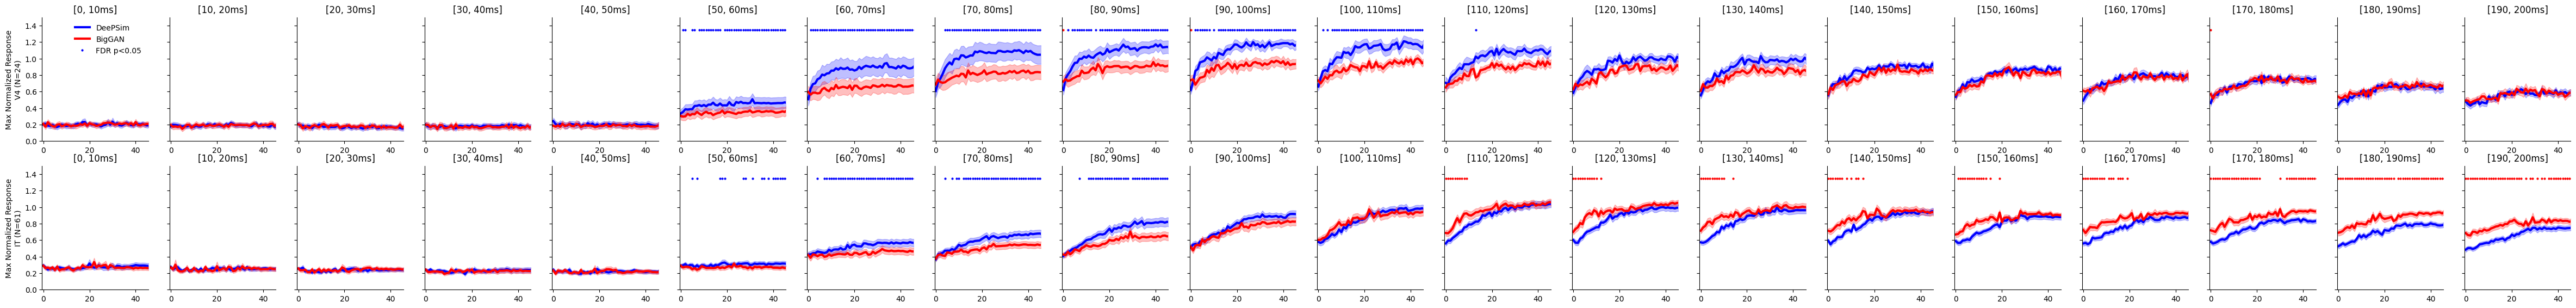

/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_49951/1646937047.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figh.show()


Exp 003 Beto-22072020-002 Pref chan5 U2
image size [3. 3.] deg  pos [-0.7  1. ]
Evol thr0: fc6   thr1: BigGAN_class
Exp 004 Beto-22072020-003 Pref chan5 U2
image size [6. 6.] deg  pos [-0.7  1. ]
Evol thr0: BigGAN_class   thr1: BigGAN_class
Exp 005 Beto-23072020-002 Pref chan29 U2
image size [3. 3.] deg  pos [-0.8  1. ]
Evol thr0: fc6   thr1: BigGAN_class
Exp 006 Beto-27072020-002 Pref chan26 U1
image size [3. 3.] deg  pos [-1.1  0. ]
Evol thr0: fc6   thr1: BigGAN_class
Exp 007 Beto-28072020-003 Pref chan15 U1
image size [3. 3.] deg  pos [-0.5  1. ]
Evol thr0: fc6   thr1: BigGAN
Exp 008 Beto-28072020-006 Pref chan15 U1
image size [3. 3.] deg  pos [-0.5  1. ]
Evol thr0: BigGAN_class   thr1: BigGAN
Exp 009 Beto-29072020-002 Pref chan28 U1
image size [3. 3.] deg  pos [0.  0.5]
Evol thr0: fc6   thr1: BigGAN_class
Exp 010 Beto-29072020-003 Pref chan18 U1
image size [4. 4.] deg  pos [-0.5  1. ]
Evol thr0: fc6   thr1: BigGAN_class
Exp 012 Beto-31072020-003 Pref chan29 U2
image size [3. 3.] de

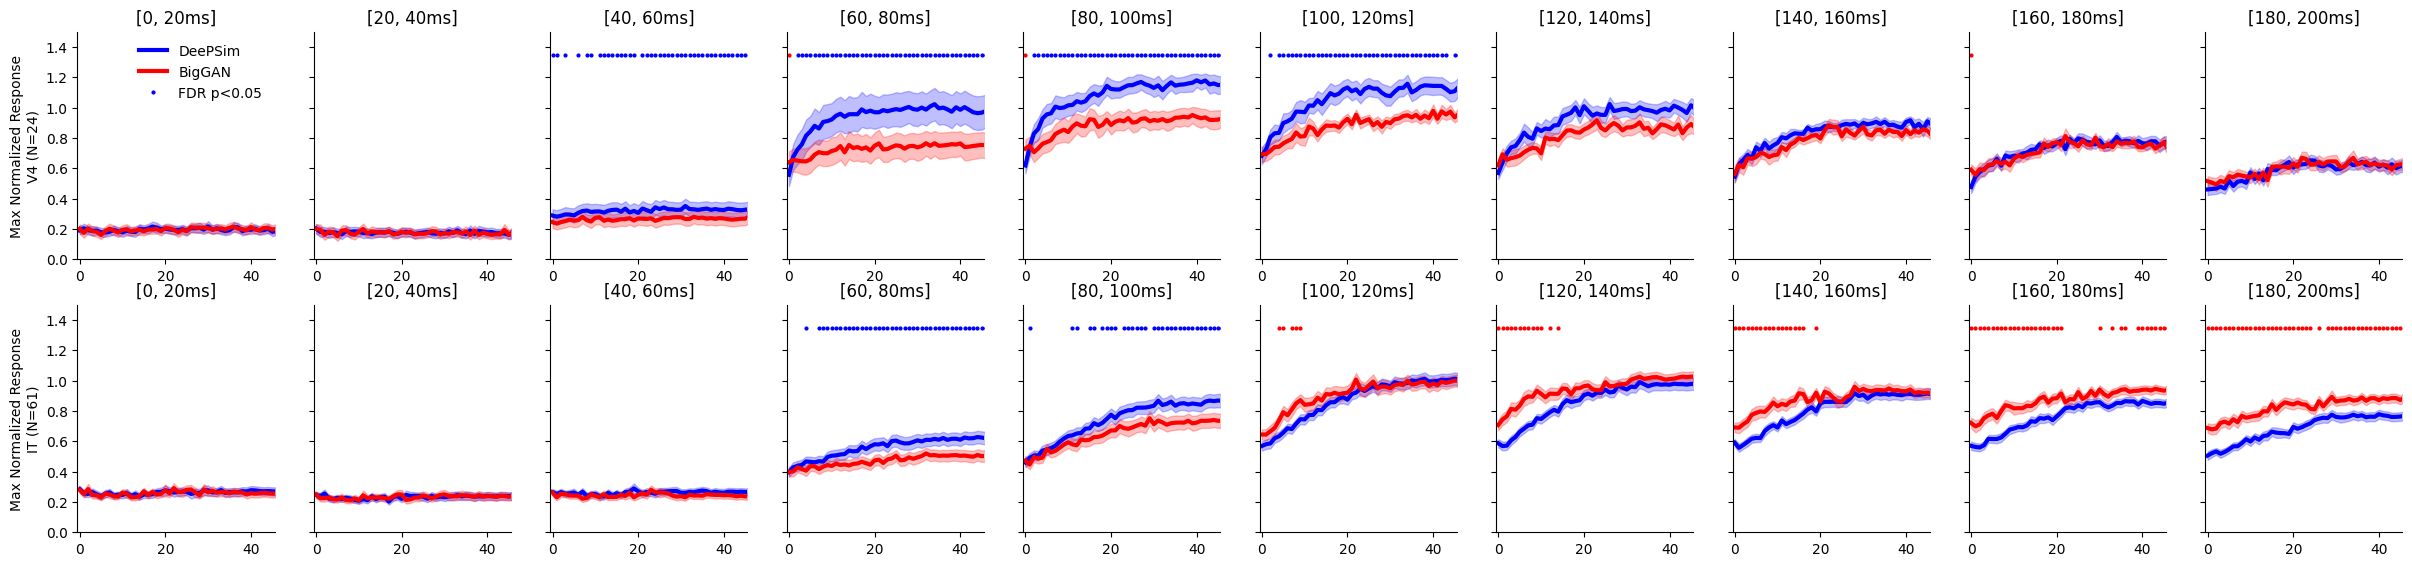

/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_49951/1646937047.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figh.show()


Exp 003 Beto-22072020-002 Pref chan5 U2
image size [3. 3.] deg  pos [-0.7  1. ]
Evol thr0: fc6   thr1: BigGAN_class
Exp 004 Beto-22072020-003 Pref chan5 U2
image size [6. 6.] deg  pos [-0.7  1. ]
Evol thr0: BigGAN_class   thr1: BigGAN_class
Exp 005 Beto-23072020-002 Pref chan29 U2
image size [3. 3.] deg  pos [-0.8  1. ]
Evol thr0: fc6   thr1: BigGAN_class
Exp 006 Beto-27072020-002 Pref chan26 U1
image size [3. 3.] deg  pos [-1.1  0. ]
Evol thr0: fc6   thr1: BigGAN_class
Exp 007 Beto-28072020-003 Pref chan15 U1
image size [3. 3.] deg  pos [-0.5  1. ]
Evol thr0: fc6   thr1: BigGAN
Exp 008 Beto-28072020-006 Pref chan15 U1
image size [3. 3.] deg  pos [-0.5  1. ]
Evol thr0: BigGAN_class   thr1: BigGAN
Exp 009 Beto-29072020-002 Pref chan28 U1
image size [3. 3.] deg  pos [0.  0.5]
Evol thr0: fc6   thr1: BigGAN_class
Exp 010 Beto-29072020-003 Pref chan18 U1
image size [4. 4.] deg  pos [-0.5  1. ]
Evol thr0: fc6   thr1: BigGAN_class
Exp 012 Beto-31072020-003 Pref chan29 U2
image size [3. 3.] de

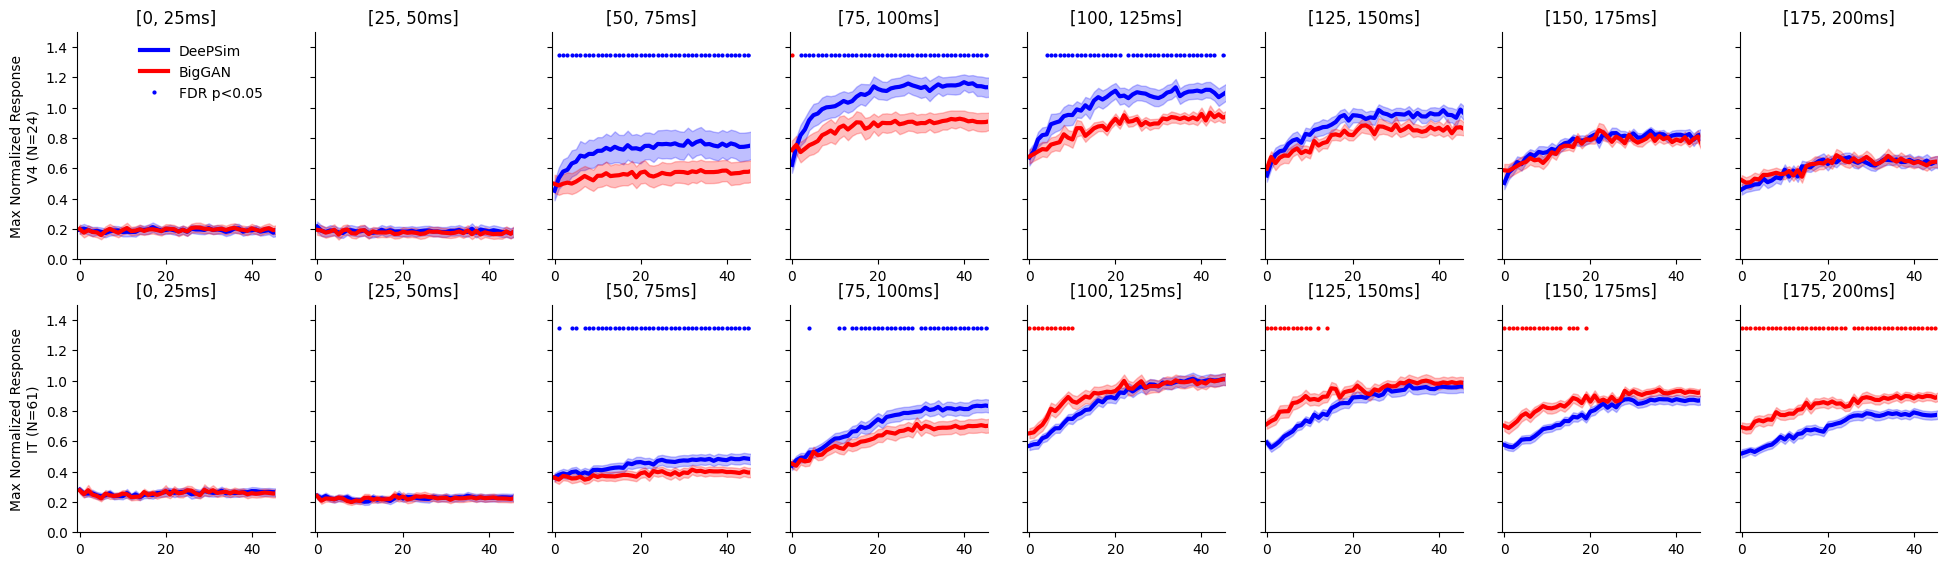

/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_49951/1646937047.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figh.show()


Exp 003 Beto-22072020-002 Pref chan5 U2
image size [3. 3.] deg  pos [-0.7  1. ]
Evol thr0: fc6   thr1: BigGAN_class
Exp 004 Beto-22072020-003 Pref chan5 U2
image size [6. 6.] deg  pos [-0.7  1. ]
Evol thr0: BigGAN_class   thr1: BigGAN_class
Exp 005 Beto-23072020-002 Pref chan29 U2
image size [3. 3.] deg  pos [-0.8  1. ]
Evol thr0: fc6   thr1: BigGAN_class
Exp 006 Beto-27072020-002 Pref chan26 U1
image size [3. 3.] deg  pos [-1.1  0. ]
Evol thr0: fc6   thr1: BigGAN_class
Exp 007 Beto-28072020-003 Pref chan15 U1
image size [3. 3.] deg  pos [-0.5  1. ]
Evol thr0: fc6   thr1: BigGAN
Exp 008 Beto-28072020-006 Pref chan15 U1
image size [3. 3.] deg  pos [-0.5  1. ]
Evol thr0: BigGAN_class   thr1: BigGAN
Exp 009 Beto-29072020-002 Pref chan28 U1
image size [3. 3.] deg  pos [0.  0.5]
Evol thr0: fc6   thr1: BigGAN_class
Exp 010 Beto-29072020-003 Pref chan18 U1
image size [4. 4.] deg  pos [-0.5  1. ]
Evol thr0: fc6   thr1: BigGAN_class
Exp 012 Beto-31072020-003 Pref chan29 U2
image size [3. 3.] de

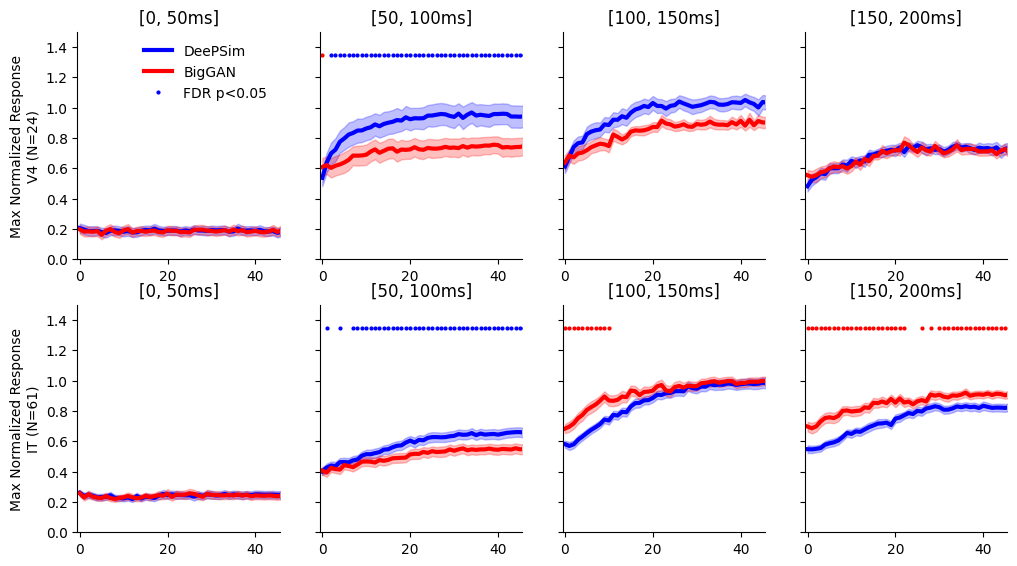

/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_49951/1646937047.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figh.show()


In [32]:
# for wdw_col_str, rsp_wdws in window_configs:
for window_length  in (10, 20, 25, 50):
    wdw_col_str = f"{window_length}ms_wdw"
    rsp_wdws = [range(i*window_length, (i+1)*window_length) for i in range(200//window_length)]
    resp_col_multi_wdw, _ = extract_all_evol_trajectory_dyna_multiwindow_nostats(BFEStats, 
                                                                                 rsp_wdws=rsp_wdws)

    normresp_extrap_arr_univ_col = pad_normalize_multi_wdw_resp_trajs(rsp_wdws, resp_col_multi_wdw, full_normalizer, )
    for commonmsk, commonmsk_title_str, commonmsk_str in [(validmsk & bothsucsmsk, "Valid & Both Success",  "valid_bothsucc"),
                                                        # (validmsk & sucsmsk, "Valid & Any Success", "valid_succ"),
                                                        # (validmsk, "Valid", "valid"),
                                                        ]:
        figh = plot_normalized_response_trajectories_from_precomputed_normresp(normresp_extrap_arr_univ_col, 
                                [V4msk, ITmsk], ["V4", "IT"], 
                                commonmsk, signif_alpha=0.05, signif_test=True, 
                                plot_individual_exp=False, mcc_corrections=["fdr"])
        figh.suptitle(
            f"Universal Max Normalized response {wdw_col_str} across blocks [{commonmsk_title_str} Sessions]")
        figh.tight_layout()
        # saveallforms([outdir, figdir], f"univmaxnorm_resp_traj_{commonmsk_str}_area_sep_{wdw_col_str}_synopsis_annot_sigif_mcc_fdr_V4IT", figh=figh)
        figh.show()

In [35]:
slice_names = ["DeePSim_mean", "BigGAN_mean", "DeePSim_sem", "BigGAN_sem"]
for window_length  in (10, 20, 25, 50):
    wdw_col_str = f"{window_length}ms_wdw"
    rsp_wdws = [range(i*window_length, (i+1)*window_length) for i in range(200//window_length)]
    resp_col_multi_wdw, _ = extract_all_evol_trajectory_dyna_multiwindow_nostats(BFEStats, 
                                                                                    rsp_wdws=rsp_wdws)

    normresp_extrap_arr_univ_col = pad_normalize_multi_wdw_resp_trajs(rsp_wdws, resp_col_multi_wdw, full_normalizer, )
    for i, (rsp_wdw, normresp_extrap_arr_univ) in \
        enumerate(normresp_extrap_arr_univ_col.items()):
        for j, slice_name in enumerate(slice_names):  # save slices 0,1,2,3
            savepath = join(source_data_dir, f"FigureExtended4C_src_normresp_wdw_{rsp_wdw.start}-{rsp_wdw.stop}_{slice_name}.csv")
            df = pd.DataFrame(normresp_extrap_arr_univ[:, :, j])
            df.to_csv(savepath, index=False)

Exp 003 Beto-22072020-002 Pref chan5 U2
image size [3. 3.] deg  pos [-0.7  1. ]
Evol thr0: fc6   thr1: BigGAN_class
Exp 004 Beto-22072020-003 Pref chan5 U2
image size [6. 6.] deg  pos [-0.7  1. ]
Evol thr0: BigGAN_class   thr1: BigGAN_class
Exp 005 Beto-23072020-002 Pref chan29 U2
image size [3. 3.] deg  pos [-0.8  1. ]
Evol thr0: fc6   thr1: BigGAN_class
Exp 006 Beto-27072020-002 Pref chan26 U1
image size [3. 3.] deg  pos [-1.1  0. ]
Evol thr0: fc6   thr1: BigGAN_class
Exp 007 Beto-28072020-003 Pref chan15 U1
image size [3. 3.] deg  pos [-0.5  1. ]
Evol thr0: fc6   thr1: BigGAN
Exp 008 Beto-28072020-006 Pref chan15 U1
image size [3. 3.] deg  pos [-0.5  1. ]
Evol thr0: BigGAN_class   thr1: BigGAN
Exp 009 Beto-29072020-002 Pref chan28 U1
image size [3. 3.] deg  pos [0.  0.5]
Evol thr0: fc6   thr1: BigGAN_class
Exp 010 Beto-29072020-003 Pref chan18 U1
image size [4. 4.] deg  pos [-0.5  1. ]
Evol thr0: fc6   thr1: BigGAN_class
Exp 012 Beto-31072020-003 Pref chan29 U2
image size [3. 3.] de

### Reproduce figure

In [36]:
meta_df = pd.read_csv(join(source_data_dir, f"FigureExt4_meta_df.csv"), index_col=0)
V1msk = meta_df.visual_area == "V1"
V4msk = meta_df.visual_area == "V4"
ITmsk = meta_df.visual_area == "IT"
validmsk = meta_df.valid
thresh = 0.01
bothsucsmsk = (meta_df.p_maxinit_0 < thresh) & (meta_df.p_maxinit_1 < thresh)
FCsucsmsk = (meta_df.p_maxinit_0 < thresh)
BGsucsmsk = (meta_df.p_maxinit_1 < thresh)

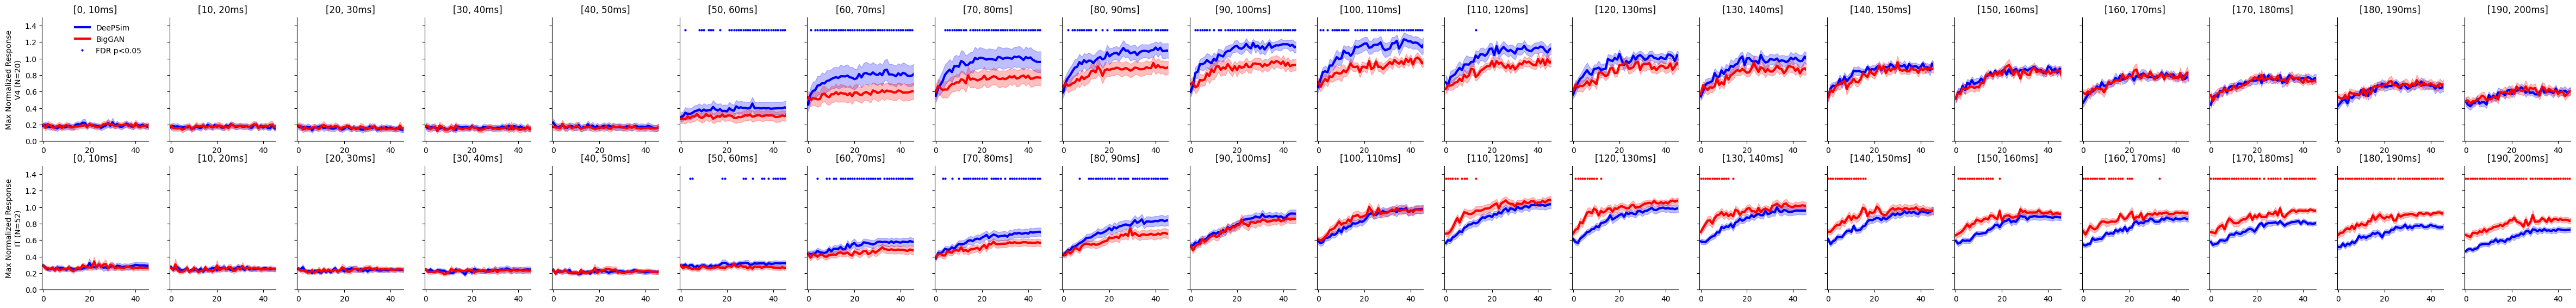

/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_49951/4111737530.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figh.show()


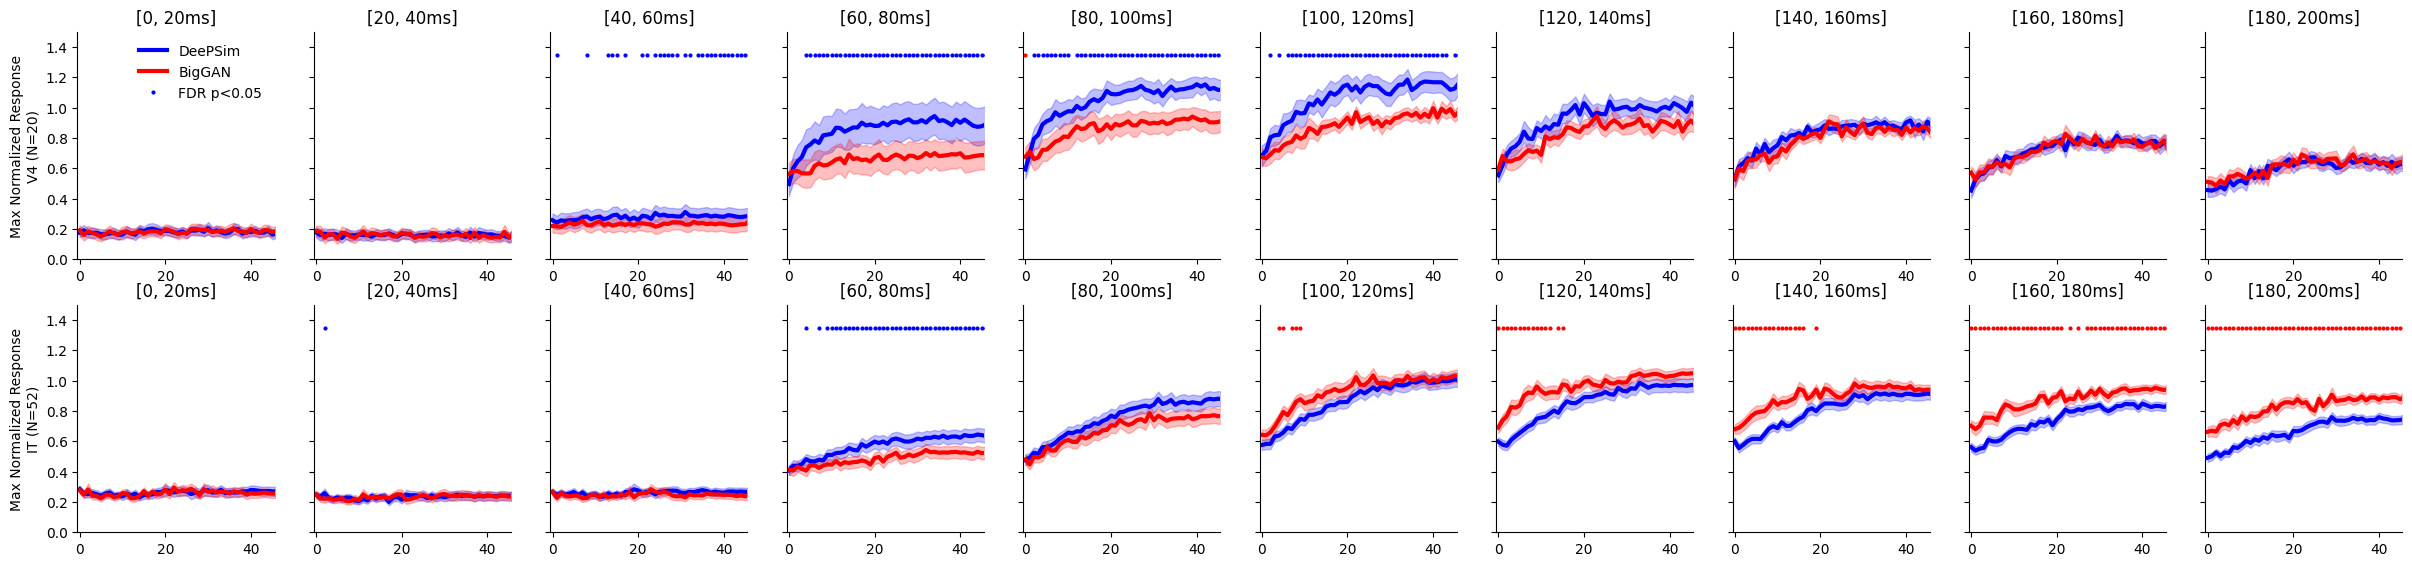

/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_49951/4111737530.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figh.show()


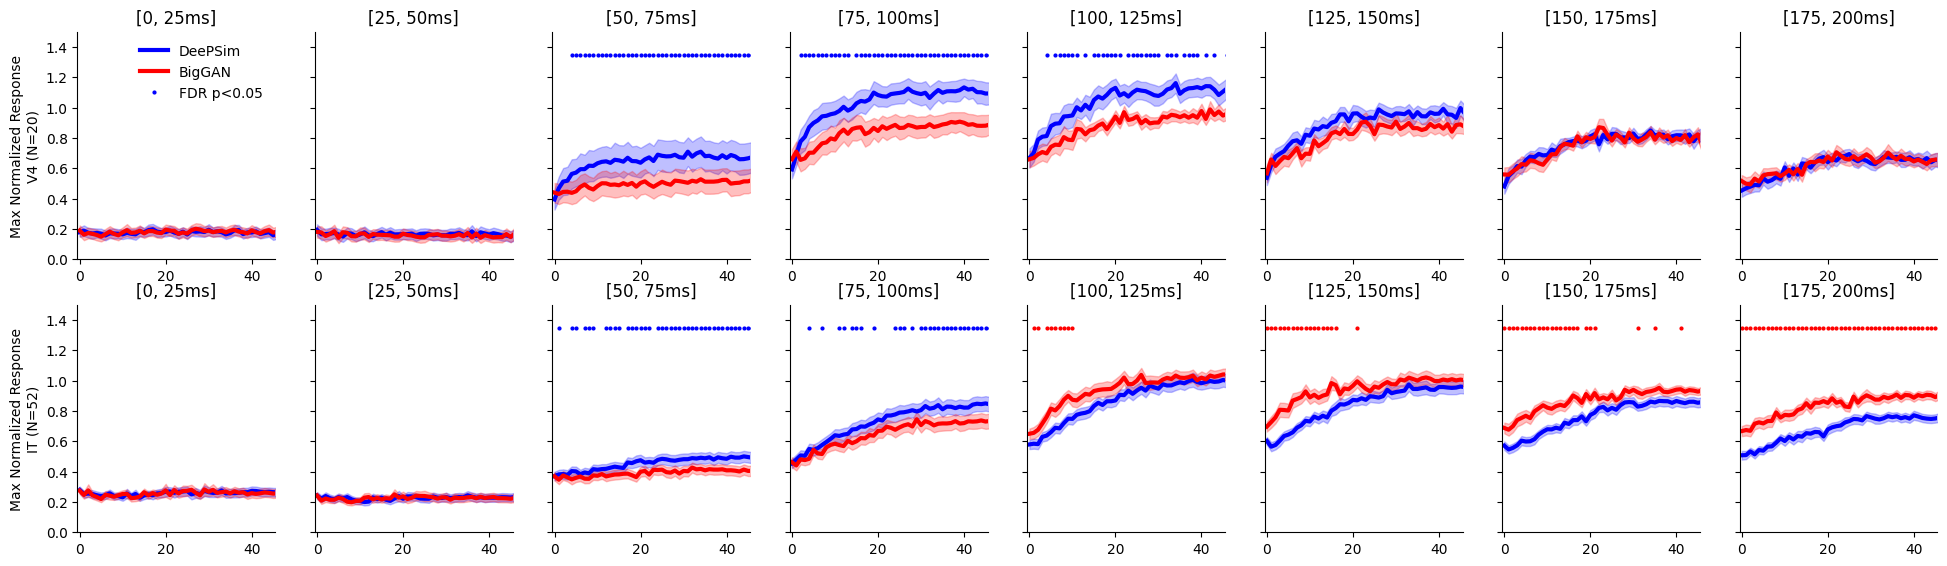

/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_49951/4111737530.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figh.show()


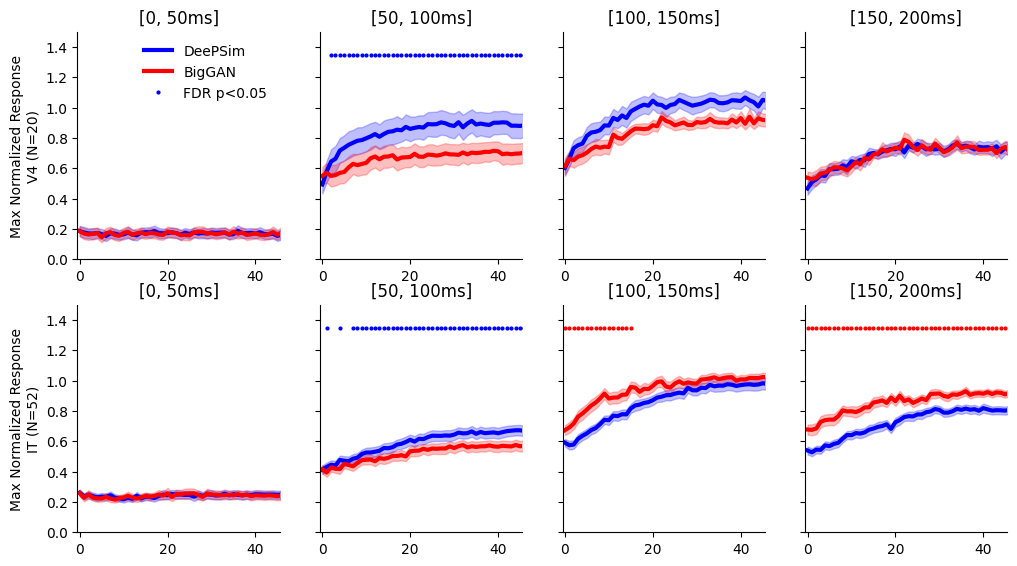

/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_49951/4111737530.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figh.show()


In [37]:
# for wdw_col_str, rsp_wdws in window_configs:
slice_names = ["DeePSim_mean", "BigGAN_mean", "DeePSim_sem", "BigGAN_sem"]
for window_length  in (10, 20, 25, 50):
    wdw_col_str = f"{window_length}ms_wdw"
    rsp_wdws = [range(i*window_length, (i+1)*window_length) for i in range(200//window_length)]
    normresp_extrap_arr_univ_col = {}
    for rsp_wdw in rsp_wdws:
        slices = []
        for slice_name in slice_names:
            savepath = join(source_data_dir, f"FigureExtended4C_src_normresp_wdw_{rsp_wdw.start}-{rsp_wdw.stop}_{slice_name}.csv")
            df = pd.read_csv(savepath)
            slices.append(df.values)
        # Stack along the last axis and store in the dict
        normresp_extrap_arr_univ_col[rsp_wdw] = np.stack(slices, axis=-1)
    
    for commonmsk, commonmsk_title_str, commonmsk_str in [(validmsk & bothsucsmsk, "Valid & Both Success",  "valid_bothsucc"),
                                                        # (validmsk & sucsmsk, "Valid & Any Success", "valid_succ"),
                                                        # (validmsk, "Valid", "valid"),
                                                        ]:
        figh = plot_normalized_response_trajectories_from_precomputed_normresp(normresp_extrap_arr_univ_col, 
                                [V4msk, ITmsk], ["V4", "IT"], 
                                commonmsk, signif_alpha=0.05, signif_test=True, 
                                plot_individual_exp=False, mcc_corrections=["fdr"],
                                panel_width=3, panel_height=3)
        figh.suptitle(
            f"Universal Max Normalized response {wdw_col_str} across blocks [{commonmsk_title_str} Sessions]")
        figh.tight_layout()
        # saveallforms([outdir, figdir], f"univmaxnorm_resp_traj_{commonmsk_str}_area_sep_{wdw_col_str}_synopsis_annot_sigif_mcc_fdr_V4IT", figh=figh)
        figh.show()